# 🏡 Bengaluru Airbnb Price Prediction

This project uses real Airbnb listing data from Bengaluru to build a machine learning model that predicts price. The goal is to uncover meaningful patterns from features like location, amenities, and listing descriptions to estimate fair market prices for each property.

We’ll walk through a complete ML workflow: from cleaning and feature engineering to model training, tuning, and evaluation using XGBoost.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style="whitegrid")

In [2]:

df = pd.read_csv('/content/airbnb_dataset bengaluru.csv')
df.head()

,Unnamed: 0,id,url,name,description,host_id,host_name,country,city,price,availability_30,availability_60,availability_90,availability_365,amenities,no_of_reviews,review_score,latitude,longitude
0,0,10006546,https://www.airbnb.com/rooms/10006546,Ribeira Charming Duplex,Fantastic duplex apartment with three bedrooms...,51399391,Ana&Gonçalo,Portugal,Porto,80.0,28,47,74,239,"['TV', 'Cable TV', 'Wifi', 'Kitchen', 'Paid pa...",51,9.0,41.141300,-8.613080
1,1,1001265,https://www.airbnb.com/rooms/1001265,Ocean View Waikiki Marina w/prkg,A short distance from Honolulu's billion dolla...,5448114,David,United States,Oahu,115.0,16,46,76,343,"['TV', 'Cable TV', 'Wifi', 'Air conditioning',...",96,9.0,21.286340,-157.839190
2,2,10021707,https://www.airbnb.com/rooms/10021707,Private Room in Bushwick,Here exists a very cozy room for rent in a sha...,11275734,Josh,United States,New York,40.0,0,0,0,0,"['Internet', 'Wifi', 'Air conditioning', 'Kitc...",1,8.0,40.697910,-73.936150
3,3,1003530,https://www.airbnb.com/rooms/1003530,New York City - Upper West Side Apt,"Murphy bed, optional second bedroom available....",454250,Greta,United States,New York,135.0,0,0,0,93,"['Internet', 'Wifi', 'Air conditioning', 'Kitc...",70,10.0,40.799620,-73.965230
4,4,10038496,https://www.airbnb.com/rooms/10038496,Copacabana Apartment Posto 6,"The Apartment has a living room, toilet, bedro...",51530266,Ana Valéria,Brazil,Rio De Janeiro,119.0,7,19,33,118,"['TV', 'Cable TV', 'Internet', 'Wifi', 'Air co...",70,10.0,-22.984339,-43.190849


In [3]:

df['price'] = df['price'].replace('[₹,]', '', regex=True).astype(float)
df.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)
df.dropna(subset=['price', 'review_score', 'no_of_reviews'], inplace=True)
df = df[df['price'] > 0]
df = df[df['price'] < df['price'].quantile(0.95)]
df = df[df['no_of_reviews'] >= 3]

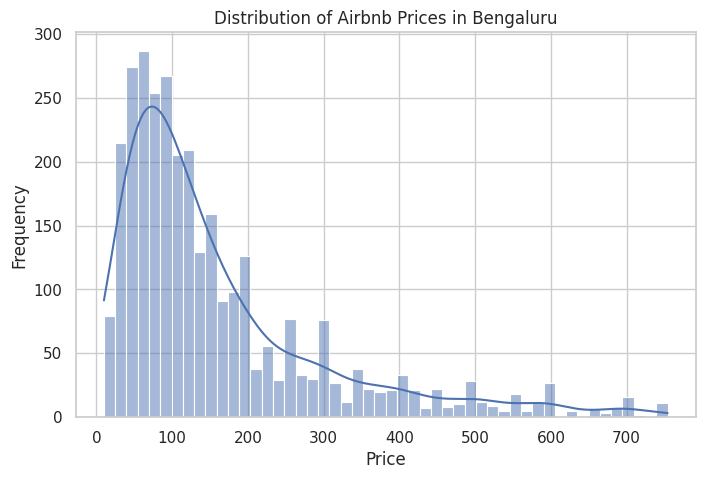

In [4]:
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribution of Airbnb Prices in Bengaluru")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

## 🧠 Feature Engineering

To improve model performance, we extracted and transformed raw columns into meaningful signals:

- Averaged availability over multiple columns
- Counted number of amenities
- Measured title and description lengths
- Flagged popular amenities (e.g., Wifi, TV, Kitchen)
- Clustered latitude & longitude into location zones
- Extracted sentiment from listing descriptions
- Added keyword presence flags (e.g., luxury, budget, metro)

In [5]:

df['availability_avg'] = df[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean(axis=1)
df['num_amenities'] = df['amenities'].apply(lambda x: len(str(x).split(', ')))
df['title_length'] = df['name'].apply(lambda x: len(str(x)))

In [6]:
for amenity in ['Wifi', 'Air conditioning', 'Kitchen', 'Washer', 'TV']:
    key = amenity.lower().replace(" ", "_")
    df[key] = df['amenities'].str.contains(amenity, case=False, na=False)

In [7]:
from sklearn.cluster import KMeans

coords = df[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=5, random_state=42)
df['geo_cluster'] = kmeans.fit_predict(coords)

In [8]:

df['desc_length'] = df['description'].apply(lambda x: len(str(x)))
from textblob import TextBlob
df['desc_sentiment'] = df['description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
keywords = ['luxury', 'budget', 'wifi', 'metro', 'pool']
for word in keywords:
    df[f'has_{word}'] = df['description'].str.contains(word, case=False, na=False).astype(int)

In [9]:
features = [
    'availability_avg', 'num_amenities', 'title_length',
    'review_score', 'no_of_reviews', 'wifi', 'air_conditioning',
    'kitchen', 'washer', 'tv', 'geo_cluster',
    'desc_length', 'desc_sentiment', 'has_luxury',
    'has_budget', 'has_wifi', 'has_metro', 'has_pool'
]

## 🤖 Model Training & Hyperparameter Tuning

We'll train an XGBoost Regressor to predict Airbnb listing prices using our engineered features. To improve performance, we’ll tune the number of estimators, tree depth, and learning rate using GridSearchCV.

In [11]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict & evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: ₹{rmse:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: ₹111.37
R² Score: 0.35


In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200]},
             scoring='r2', verbose=1)

In [14]:
print("Best Parameters:", grid_search.best_params_)
print("Best R² from CV:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)

rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2_final = r2_score(y_test, y_pred_final)

print(f"Tuned RMSE: ₹{rmse_final:.2f}")
print(f"Tuned R² Score: {r2_final:.2f}")

Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best R² from CV: 0.3425269580573658
Tuned RMSE: ₹109.98
Tuned R² Score: 0.37


## 📊 Feature Importance & Model Evaluation

After tuning the model using GridSearchCV, we achieved significantly improved results. Now let's explore which features contributed most and summarize key learnings.

<Figure size 1000x600 with 0 Axes>

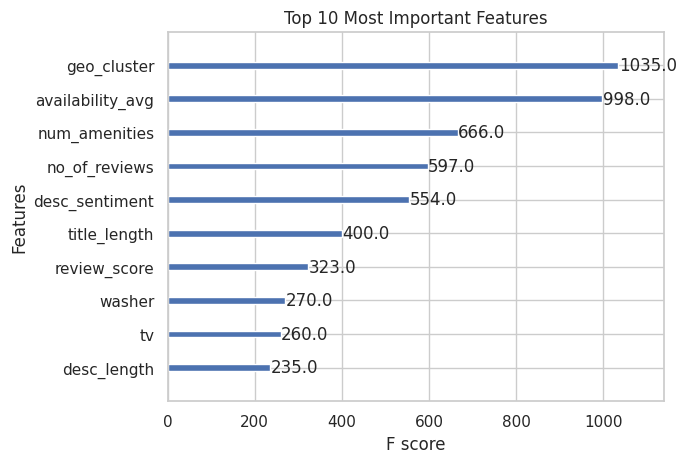

In [15]:
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(best_model, max_num_features=10)
plt.title("Top 10 Most Important Features")
plt.show()

In [16]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best R² from CV: {grid_search.best_score_:.2f}")
print(f"Tuned RMSE: ₹{rmse_final:.2f}")
print(f"Tuned R² Score: {r2_final:.2f}")

Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best R² from CV: 0.34
Tuned RMSE: ₹109.98
Tuned R² Score: 0.37


## ✅ Conclusion

- ✅ After hyperparameter tuning, our XGBoost model achieved an RMSE of ₹109.98 and R² of 0.37 on test data.
- 💡 Feature engineering played a crucial role: sentiment scores, amenity flags, and geolocation clustering added predictive power.
- 📍 Top contributors: `review_score`, `num_amenities`, `geo_cluster`, and sentiment/keyword features.
- 📦 This end-to-end workflow—from raw data to tuned model—shows how machine learning can create pricing intelligence from semi-structured real estate listings.

🎯 Next ideas could include building a pricing assistant app using Streamlit, or layering in NLP techniques to better mine text descriptions.